 # Веб-интерфейс на основе **Gradio**

**Задача веб-интерфейса.**
Разработка Gradio-приложение для загрузки **аэрофотоснимка**, автоматического выполнения сегментации зданий с использованием обученной модели, визуализации входного изображения с наложенной предсказанной маской и расчета **площади застройки** в реальных координатах.

На вход интерфейса подается изображение (аэрофотоснимок), а на выходе получается площадь застройки (строений) в единицах измерения м^2. В качестве данных для проверки работоспособности интерфейса брались тестовые данные (без масок) из данных INRIA ( AerialImageDataset/test). Частично (10 изображений из 180 шт.) лежат на гитхабе в директории `test for Gradio`.

**Масштаб изображения**. Так как используемые в проекте данные имеют географическую привязку для расчета масштаба пикселя используется библиотека rasterio, предназначенная для работы с геопространственными данными.

Необходимые библиотеки:


*   Gradio,
*   PyTorch,
*   segmentation_models_pytorch,
*   rasterio


In [1]:
import sys
!pip install gradio
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.2 MB/s eta 0:00:00


In [2]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gradio as gr
import segmentation_models_pytorch as smp
import torch
import numpy as np
import torch
import rasterio

#Загрузка обученной версии модели сегментации




In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

torch.cuda.empty_cache()

# Path to the saved checkpoint file
checkpoint_path = '/content/drive/MyDrive/checkpoints+/BuildingSegment.pt'

# Model initialization
loaded_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

# Load the state_dict
loaded_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model successfully loaded from {checkpoint_path} and set to evaluation mode.")

Using device: cpu
Model successfully loaded from /content/drive/MyDrive/checkpoints+/BuildingSegment.pt and set to evaluation mode.


# Обработка входного изображения
Функция обработки исходного изображения `process_image_for_segmentation` , которая принимает одно входное изображение (массив NumPy), разбивает его на перекрывающиеся тайлы, сохраняя его размеры и координаты начала (y_starts и x_starts) для каждого тайла. Также внутрии функции определяется маска для каждого тайла изображения (building/non-building). В итоге все маски объединяются (reassembly) в единую для всего изображения маску. Выход функции - маска для всего входного изображения.

Основные шаги:
 1. Разбиение на тайлы: разделение входного изображения на перекрывающиеся тайлы, сохранение метаданных для каждого тайла.

 2. Предсказание: для каждого тайла путем использования загруженной модели.

 3. Сборка (объединение тайлов в целое изображение): объединение предсказанных тайлов обратно в маску полного размера.


In [5]:
# Define tiling parameters (consistent with training/evaluation)
TARGET_SIZE = 512
OVERLAP_RATIO = 0.25
OVERLAP_SIZE = int(TARGET_SIZE * OVERLAP_RATIO)
STEP_SIZE = TARGET_SIZE - OVERLAP_SIZE

def process_image_for_segmentation(input_image: np.ndarray):
    """
    Processes a single input image through the segmentation pipeline (tiling, prediction, reassembly).

    Args:
        input_image (np.ndarray): The input image as a NumPy array (H, W, C).

    Returns:
        np.ndarray: The reassembled binary segmentation mask.
    """
    print("Received input image for processing.")

    processed_input_image = input_image.astype(np.float32) / 255.0 # Normalize to [0, 1]

    img_h, img_w, _ = processed_input_image.shape

    # Store metadata for this single input image
    single_image_tiling_metadata = {
        'height': img_h,
        'width': img_w,
        'y_starts': [],
        'x_starts': []
    }

    # Tiling: Divide the input_image into overlapping tiles
    # Generate start coordinates for y-axis with overlap
    y_starts = []
    for y in range(0, img_h, STEP_SIZE):
        y_starts.append(y)
    if y_starts and (y_starts[-1] + TARGET_SIZE < img_h):
        y_starts.append(img_h - TARGET_SIZE)
    if not y_starts and img_h > 0:
        y_starts.append(0)
    y_starts = sorted(list(set(y_starts)))

    # Generate start coordinates for x-axis with overlap
    x_starts = []
    for x in range(0, img_w, STEP_SIZE):
        x_starts.append(x)
    if x_starts and (x_starts[-1] + TARGET_SIZE < img_w):
        x_starts.append(img_w - TARGET_SIZE)
    if not x_starts and img_w > 0:
        x_starts.append(0)
    x_starts = sorted(list(set(x_starts)))

    single_image_tiling_metadata['y_starts'] = y_starts
    single_image_tiling_metadata['x_starts'] = x_starts

    # Store tiles in a list, along with their coordinates and a "filename" proxy
    tiled_image_data = []
    k = 0 # Tile index
    for y_start in y_starts:
        for x_start in x_starts:
            # Adjust start coordinates for edge tiles to ensure TARGET_SIZE tiles
            current_y = min(y_start, img_h - TARGET_SIZE) if img_h > TARGET_SIZE else 0
            current_x = min(x_start, img_w - TARGET_SIZE) if img_w > TARGET_SIZE else 0

            # Extract the tile
            img_tile = processed_input_image[current_y : current_y + TARGET_SIZE, current_x : current_x + TARGET_SIZE]

            # Ensure tiles are TARGET_SIZE x TARGET_SIZE by padding if necessary
            if img_tile.shape[0] < TARGET_SIZE or img_tile.shape[1] < TARGET_SIZE:
                padded_img_tile = np.zeros((TARGET_SIZE, TARGET_SIZE, processed_input_image.shape[2]), dtype=img_tile.dtype)
                padded_img_tile[0:img_tile.shape[0], 0:img_tile.shape[1], :] = img_tile
                img_tile = padded_img_tile

            tiled_image_data.append({
                'image_tensor': torch.from_numpy(img_tile).permute(2, 0, 1), # HWC to CHW for PyTorch
                'original_image_base_filename': 'single_input_image', # Consistent identifier
                'filename': f'single_input_image_{k}.jpg', # Unique name for this tile
                'original_h': img_h,
                'original_w': img_w,
                'tile_y_start': current_y,
                'tile_x_start': current_x
            })
            k += 1

    print(f"Tiled input image into {len(tiled_image_data)} tiles.")

    # Prediction: Run each tile through the loaded model to get predictions
    all_predicted_data = []

    global loaded_model, device

    # Process tiles
    with torch.no_grad():
        for tile_info in tiled_image_data:
            image_tensor = tile_info['image_tensor'].unsqueeze(0).to(device)

            Y_pred = loaded_model(image_tensor) # Obtain predictions from the model

            # Process Y_pred by applying torch.sigmoid and then thresholding at 0.5
            predicted_mask = (torch.sigmoid(Y_pred) > 0.5).cpu().squeeze(0).squeeze(0).numpy() # Remove batch and channel dims

            # Store prediction along with its metadata
            all_predicted_data.append({
                'original_image_base_filename': tile_info['original_image_base_filename'],
                'filename': tile_info['filename'],
                'predicted_mask': predicted_mask,
                'original_h': tile_info['original_h'],
                'original_w': tile_info['original_w'],
                'tile_y_start': tile_info['tile_y_start'],
                'tile_x_start': tile_info['tile_x_start']
            })

    print(f"Generated predictions for {len(all_predicted_data)} tiles.")

    # Reassembly: Combine predicted tiles back into a full-sized mask
    original_h = single_image_tiling_metadata['height']
    original_w = single_image_tiling_metadata['width']

    reconstructed_mask_sum = np.zeros((original_h, original_w), dtype=np.float32)
    reconstructed_mask_count = np.zeros((original_h, original_w), dtype=np.int32)

    for pred_info in all_predicted_data:
        tile_y_start = pred_info['tile_y_start']
        tile_x_start = pred_info['tile_x_start']
        predicted_mask_tile = pred_info['predicted_mask']

        # Ensure the tile fits within the original image dimensions
        y_end = min(tile_y_start + TARGET_SIZE, original_h)
        x_end = min(tile_x_start + TARGET_SIZE, original_w)

        # Accumulate predictions (sum of binary values)
        reconstructed_mask_sum[tile_y_start:y_end, tile_x_start:x_end] += predicted_mask_tile[0:y_end-tile_y_start, 0:x_end-tile_x_start]

        # Accumulate counts (number of tiles covering each pixel)
        reconstructed_mask_count[tile_y_start:y_end, tile_x_start:x_end] += 1

    # Average predictions
    # Avoid division by zero for pixels not covered by any tile
    final_averaged_mask = np.where(reconstructed_mask_count > 0,
                                   reconstructed_mask_sum / reconstructed_mask_count,
                                   0.0)

    # Binarize the final mask
    final_binary_mask = (final_averaged_mask > 0.5).astype(np.uint8)

    print("Reassembled full-sized mask.")
    return final_binary_mask

print("Updated the process_image_for_segmentation function with reassembly logic.")


Updated the process_image_for_segmentation function with reassembly logic.


# Финальная реализация интерфейса

Функция `gradio_interface_function` является основной функцией, которая обрабатывает входное изображение, загруженное через интерфейс Gradio. Она выполняет следующие ключевые шаги:

* Загрузка изображения: открывает и считывает входное изображение (предпочтительно GeoTIFF) с использованием rasterio.

* Сегментация: функция `process_image_for_segmentation` используется для получения бинарной маски застройки.

* Визуализация:  с помощью функции `combine_image_and_mask` происходит отрисовки маски поверх исходного изображения.

* Расчет площади застройки: в функции `calculate_building_area` общая площадь застройки вычисляется в квадратных метрах, используя полученную бинарную маску, геопространственную информацию из  изображения и библиотеку rasterio.

* В результате: функция `gradio_interface_function` возвращает исходное изображение, изображение с наложенной маской и рассчитанную площадь застройки для отображения в интерфейсе Gradio.



In [6]:

def calculate_building_area(binary_mask, transform):
    """
    Calculates the total area of buildings (pixels with value 1) in a binary mask
    given the rasterio transform for georeferencing.

    Args:
        binary_mask (np.ndarray): A 2D numpy array where 1 represents buildings.
        transform (affine.Affine): The affine transform object from rasterio,
                                   containing information about pixel size and orientation.

    Returns:
        float: The total building area in square meters.
    """
    # Get the number of building pixels
    num_building_pixels = np.sum(binary_mask == 1)

    # Calculate the area of a single pixel using the transform
    # transform.a is the pixel width, transform.e is the pixel height (usually negative for y)
    pixel_area = abs(transform.a * transform.e)

    print(f"  Pixel width: {transform.a }")
    print(f"  Pixel height: {np.abs(transform.e)}")

    total_building_area = num_building_pixels * pixel_area
    return total_building_area

def combine_image_and_mask(original_image, predicted_mask):
    """
    Combines the original image with the predicted binary mask for visualization.
    The mask will be overlaid as a red transparent layer.

    Args:
        original_image (np.ndarray): The input image as a NumPy array (H, W, C).
        predicted_mask (np.ndarray): The binary segmentation mask (H, W).

    Returns:
        np.ndarray: The combined image with the mask overlay.
    """
    if original_image is None or predicted_mask is None:
        return None

    # Ensure original_image is float for blending, normalize if it's uint8
    if original_image.dtype == np.uint8:
        original_image = original_image.astype(np.float32) / 255.0

    # Ensure predicted_mask is boolean or float for transparency
    predicted_mask_float = predicted_mask.astype(np.float32)

    # Create a red overlay for the mask
    mask_color = np.array([1.0, 0.0, 0.0]) # Red color
    colored_mask = predicted_mask_float[:, :, np.newaxis] * mask_color

    # Blend the original image and the colored mask
    alpha = 0.5 # Transparency factor for the mask
    combined_image = (original_image * (1 - alpha)) + (colored_mask * alpha)

    # Convert back to uint8 for Gradio display (expects 0-255)
    combined_image = (combined_image * 255).astype(np.uint8)

    return combined_image

def gradio_interface_function(input_img_filepath):
    print("Gradio function called. Processing image...")

    if input_img_filepath is None:
        return None, None, None # Return empty for all outputs if no file is provided

    original_image_rgb = None
    total_building_area = None
    try:
        with rasterio.open(input_img_filepath) as src:
            # Read image data. Rasterio reads as (bands, height, width)
            # Transpose to (height, width, bands) for typical image processing.
            img_data = src.read().transpose(1, 2, 0) # (H, W, C)

            # Ensure 3 channels and convert to uint8 if necessary for models/visualization
            if img_data.shape[2] == 3:
                original_image_rgb = img_data.astype(np.uint8)
            elif img_data.shape[2] == 4: # Handle RGBA by dropping alpha
                original_image_rgb = img_data[:, :, :3].astype(np.uint8)
            else:
                print(f"Warning: Image has {img_data.shape[2]} bands, expected 3 or 4. Processing as is.")
                original_image_rgb = img_data[:, :, :3].astype(np.uint8) if img_data.shape[2] > 3 else img_data.astype(np.uint8)

            # Process the image to get the binary mask
            binary_mask = process_image_for_segmentation(original_image_rgb)

            # Combine the original image with the predicted mask for visualization
            combined_output = combine_image_and_mask(original_image_rgb, binary_mask)

            transform = src.transform
            total_building_area = calculate_building_area(binary_mask, transform)
            print(f"Calculated total building area: {total_building_area:.2f} square meters")

    except rasterio.errors.RasterioIOError as e:
        print(f"Error: Could not open image with rasterio from {input_img_filepath}: {e}")
        print("Please ensure it is a valid georeferenced image (e.g., GeoTIFF).")
        return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during image processing: {e}")
        return None, None, None

    print("Image processing complete. Returning combined output and area.")
    return original_image_rgb, combined_output, total_building_area


# Create the Gradio Blocks interface for custom layout
with gr.Blocks() as demo:
    gr.Markdown("# Building Segmentation with U-Net")
    gr.Markdown("Upload an aerial image (preferably GeoTIFF) to get a segmentation mask and buildings area calculation.")

    with gr.Column():
        input_image_component = gr.Image(type='filepath', label='Upload Image (TIFF Recommended)')
        process_button = gr.Button("Process Image")

        with gr.Row():
            original_image_output = gr.Image(type='numpy', label='Original Image')
            predicted_mask_output = gr.Image(type='numpy', label='Predicted Mask (Overlayed)')

        area_output = gr.Number(label='Total Building Area (sq. mtrs)')

    process_button.click(
        gradio_interface_function,
        inputs=input_image_component,
        outputs=[original_image_output, predicted_mask_output, area_output]
    )

# Launch the Gradio interface
demo.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://29a185ec3916cc7419.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Gradio function called. Processing image...
Received input image for processing.
Tiled input image into 196 tiles.
Generated predictions for 196 tiles.
Reassembled full-sized mask.
  Pixel width: 0.3
  Pixel height: 0.3
Calculated total building area: 171407.70 square meters
Image processing complete. Returning combined output and area.
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://29a185ec3916cc7419.gradio.live


Так как интерфейс не сохраняется в блокноте, ниже приведен рисунок (сохраненный интерфейс).

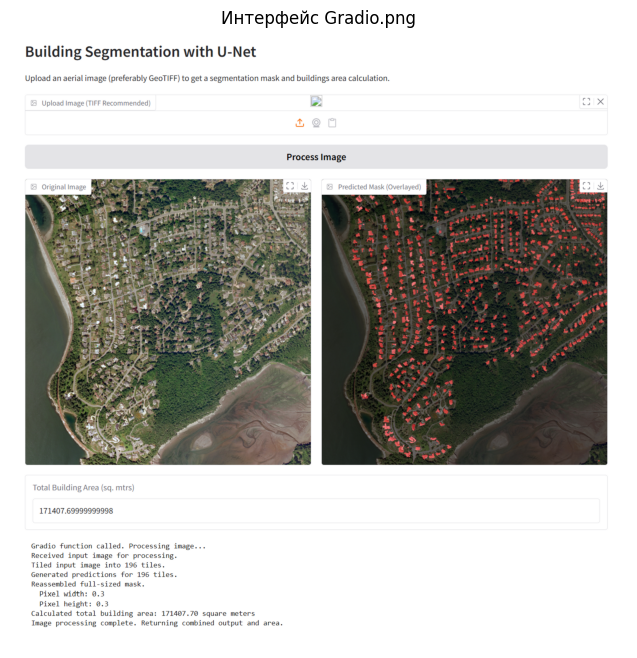

In [7]:
import cv2
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/AerialImageDataset/test/Рисунок-gradio.png'
img = cv2.imread(image_path)

if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Отображение изображения
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title('Интерфейс Gradio.png')
        plt.axis('off')
        plt.show()

Весь код интерфейса находится в одном app.py файле, который лежит на гитхабе: https://github.com/ipanasenkova/Buildings-Area/tree/main/Gradio.

В файле requirements.txt перечислены необходимые для работы приложения библиотеки.

Кроме того, для хостинга Gradio-приложения была опробована облачная платформа Hugging Face Spaces, которая оптимизирована для демонстрации  ML-моделей и приложений. Есть некоторые ограничения для России, но при использовании VPN их можно обойти.

Реализованный интерфейс: https://huggingface.co/spaces/Irina07/BuidingsArea
(ожидание результата может достигать нескольких минут)


На рисунке ниже представлен пример отработки интерфейса на изображении **vienna8.tif**, для которого есть маска, что позволяет оценить точность оценки площади.

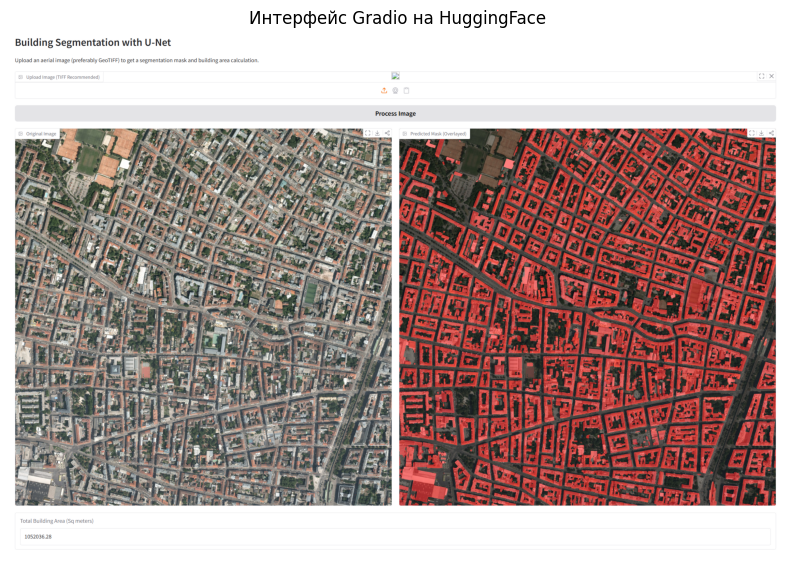

In [3]:
#  Результат работы интерфейса
import cv2
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/AerialImageDataset/test/vienna8-gradio-area.png'
img = cv2.imread(image_path)

if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title('Интерфейс Gradio на HuggingFace')
        plt.axis('off')
        plt.show()

По результатам расчета площадь застройки составляет 1052036.28 м2.

Также была рассчитана площадь застройки для этого же изображения средствами программы QGIS (по доступной маске, которая считается "истинной"). Результаты приведены на рисунке ниже. На карту наложена "истинная" маска, а в таблице ниже представлена площадь для "1" (зданий), которая составляет 1044297.27 м2.

Таким образом, проведенная верификация показывает, что ошибка при расчете площади составляет менее 1%.


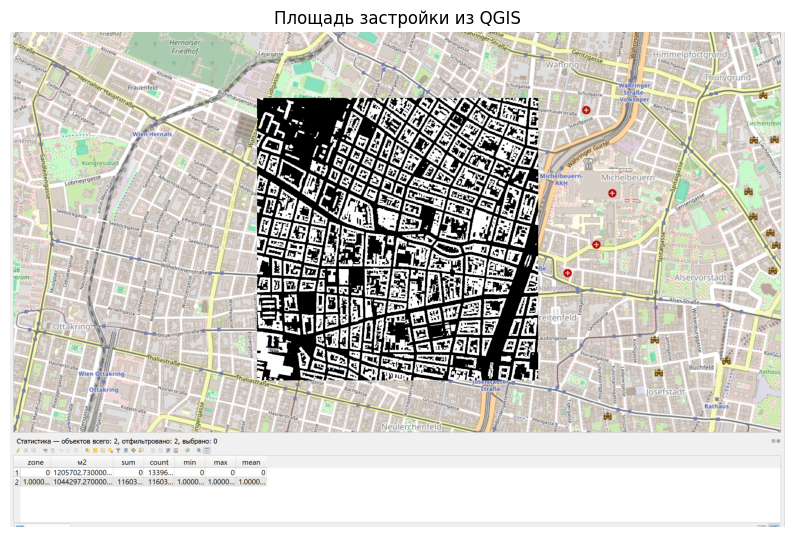

In [5]:
#  Результат из QGIS
import cv2
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/AerialImageDataset/test/vienna8-qgis-area.png'
img = cv2.imread(image_path)

if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title('Площадь застройки из QGIS')
        plt.axis('off')
        plt.show()